
# Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 21 
Patients: 499

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['clinical_index' 'dateofinitialpathologicdiagnosis' 'gleasonscore'
 'pathologyNstage' 'psavalue' 'race' 'yearstobirth']


Gene Counts data set imported!
Features: 20501 
Patients: 497


Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


# Data Exploration
## Clinical Information and metastasis label
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y'** series.  

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

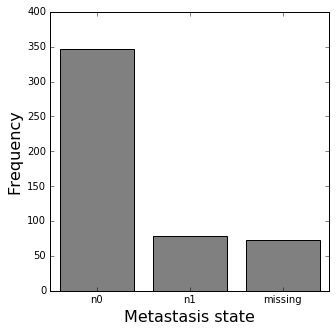

In [3]:
D = (('n0', y_all[y_all =='n0'].shape[0]), 
     ('n1', y_all[y_all =='n1'].shape[0]), 
     ('missing' , y_all[y_all.isnull()].shape[0]))
exp_fig = plt.figure(figsize=(5 , 5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this as tuples (D, in this case) are not ordered?
ep = plt.show
exp_fig.savefig('Figures/Label_count.png')

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [4]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

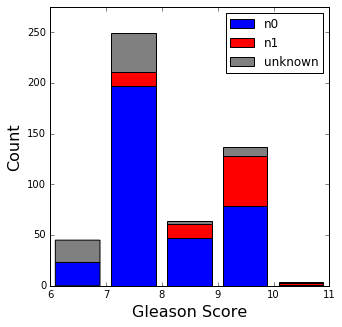

In [5]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/Gleason_hist.png')

It appears that no metastases are recorded in those specimens graded at a Gleason score of 6.  This represents an opportunity to replace the missing data label with the most likely pathology state, n0, to more efficiently use the small data set.  

In [6]:
"""Define the indices where gleasonscore == 6 and pathologyNstage is null"""
set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))

{'TCGA-2A-A8VO',
 'TCGA-2A-AAYO',
 'TCGA-CH-5738',
 'TCGA-G9-6342',
 'TCGA-G9-6347',
 'TCGA-G9-6371',
 'TCGA-G9-7509',
 'TCGA-H9-A6BX',
 'TCGA-HC-7075',
 'TCGA-HC-7077',
 'TCGA-HC-8213',
 'TCGA-HC-8259',
 'TCGA-J4-A67Q',
 'TCGA-J4-A83K',
 'TCGA-J9-A8CN',
 'TCGA-M7-A720',
 'TCGA-V1-A8WN',
 'TCGA-V1-A8WS',
 'TCGA-V1-A9OF',
 'TCGA-V1-A9OQ',
 'TCGA-V1-A9OT',
 'TCGA-XJ-A9DQ'}

In [7]:
y_all.loc[set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))] = 'n0'

/Users/ccthomps/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


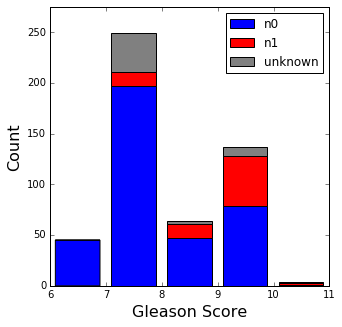

In [8]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/Gleason_hist2.png')

## Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [9]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 448
Unlabeled observations (removed:) 51


In [10]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (446, 20501) 
y dimensions: (446,)


In [11]:
X_no_y = X_all.loc[list(not_labeled.index)]
print("Dimensions of unlabeled dataset:",X_no_y.shape)

Dimensions of unlabeled dataset: (51, 20501)


In [12]:
"""Check to determine if any clinical information is missing"""
X.isnull().values.any()

False

## Data Visualization

In [13]:
gleason = clinical['gleasonscore']
age = pd.to_numeric(clinical['yearstobirth'], errors = 'coerce')
age.fillna(value = np.mean(age), inplace=True)
psa = pd.to_numeric(clinical['psavalue'], errors= 'coerce')
psa.fillna(value = np.mean(psa), inplace =True)
gleason = gleason.loc[y.index]

clinicalDF = pd.DataFrame({'gleason': gleason,
                            'age':age ,
                            'psa' : psa,
                            'y' : y}, index=X.index)

In [14]:
clinicalDF.drop(['y'], axis=1, inplace = True)

In [15]:
clinicalDF = clinicalDF.reindex(y.index)

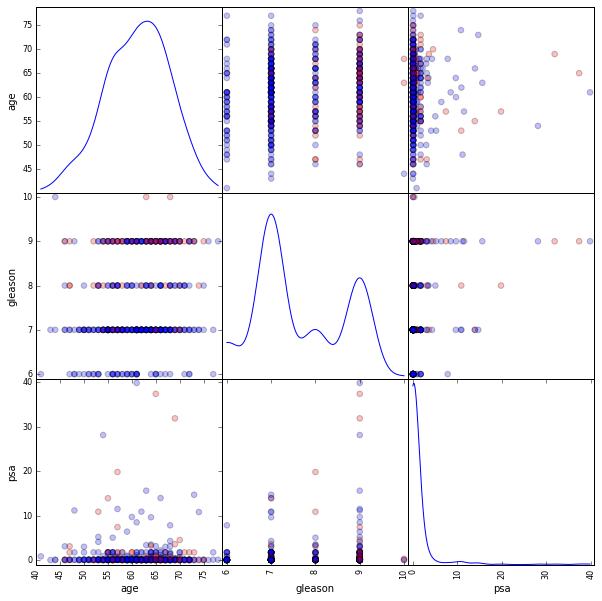

In [16]:
sm = pd.scatter_matrix(clinicalDF, 
                       alpha=0.25, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 125)

plt.savefig("Figures/clin_scatter_matrix.png")

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif
K_selector = SelectKBest(f_classif, k = 'all') # using k=all here and will filter based on F-stat later.  
K = K_selector.fit(X, y)
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9419  9421  9423  9495 10092 11101 11929 12028 12488
 12527 12593 12606 13749 13963 14015 14129 14130 14131 14132 14726 14727
 14729 15109 15111 15112 16536 16538 16539 16541 16542 16543 16545 16546
 16547 16548 16549 16550 16576 16605 16608 16648 16668 16669 16670 16671
 16672 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682 16683
 16684 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695
 16696 16697 16698 16699 16700 16701 16702 16703 16704 16705 16706 16707
 16708 16709 16710 16711 16712 16713 16714 16715 16716 16717 16718 16720
 16721 16722 16723 16724 16725 16726 16728 16729 16730 16731 16732 

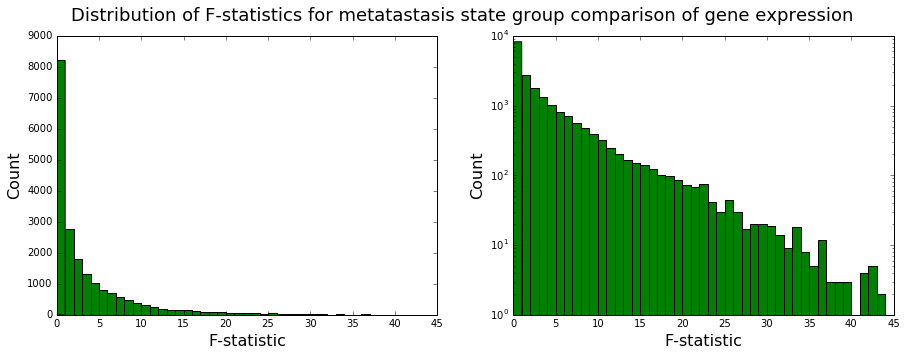

In [18]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,2,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
#A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic", fontsize=16)
F_fig.suptitle("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
B = F_fig.add_subplot(1,2,2)
B.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
B.set_yscale('log')
B.set_ylabel('Count', fontsize=16)
B.set_xlabel("F-statistic", fontsize=16)
#B.set_title("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
plt.show
F_fig.savefig("Figures/F_distribution.png")

# Analysis
## Prepare for Analysis
### Generate Scoring Functions

In [19]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score

In [20]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
LL_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True, needs_threshold=False)
MCC_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

### Import Logistic Regression Algorithms

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### Set Seed and Folds for Cross Validation

In [22]:
seed = 123
folds = 4

### Handles for Graph legends

In [23]:
import matplotlib.patches as mpatches
blue = mpatches.Patch(color ='blue', label ='n0')
red = mpatches.Patch(color='red', label = 'n1')

### Train Test Split

In [24]:
from sklearn.model_selection import train_test_split
train_k = round(len(y)*0.75)
test_k = len(y) - train_k

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

In [26]:
clinicalDF_train = clinicalDF.loc[X_train.index,:]
clinicalDF_test = clinicalDF.loc[X_test.index,:]

## Benchmark

### Clinical Information Benchmark

In [27]:
clf_LR_clin = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf_LR_clin.fit(clinicalDF_train, y_train)  #use training set for model learning

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

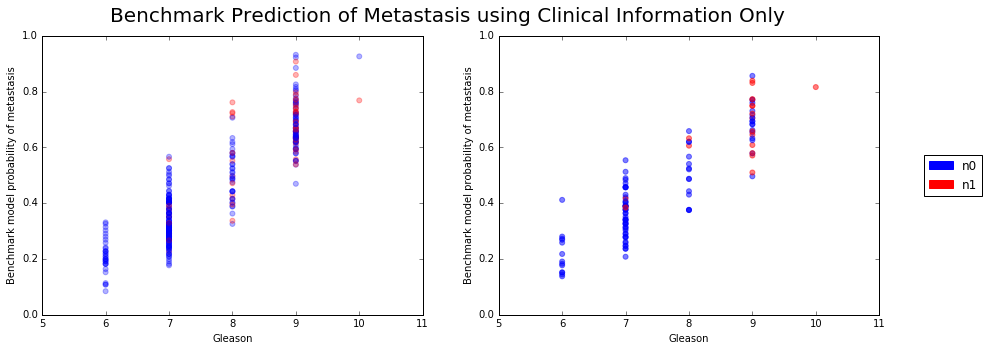

In [28]:
clf_LR_clin = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf_LR_clin.fit(clinicalDF_train, y_train)  #use training set for model learning

bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(clinicalDF_train.loc[:,'gleason'], 
          clf_LR_clin.predict_proba(clinicalDF_train)[:,1], 
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.3,
          s = 25)
A.set_ylabel('Benchmark model probability of metastasis')
A.set_xlabel('Gleason')
plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(clinicalDF_test.loc[:,'gleason'],
          clf_LR_clin.predict_proba(clinicalDF_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
B.set_xlabel('Gleason')
B.set_ylabel('Benchmark model probability of metastasis')
bench_fig.legend(labels = ['n0', 'n1'], handles = [blue, red], loc = 5)
bench_fig.suptitle("Benchmark Prediction of Metastasis using Clinical Information Only", fontsize=20)
plt.show
bench_fig.savefig('Figures/benchmark.png')

In [29]:
print(clinicalDF.columns)
clf_LR_clin.coef_

Index(['age', 'gleason', 'psa'], dtype='object')


array([[-0.05535498,  0.77196461,  0.04525214]])

In [30]:
"Benchmark Performance on Test dataset"
print(clf_LR_clin)
print('\nNull F beta: ', fbeta_score(y_test, clf_LR_clin.predict(clinicalDF_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR_clin.predict(clinicalDF_test)),"\n")
print(classification_report(y_test, clf_LR_clin.predict(clinicalDF_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR_clin.predict_proba(clinicalDF_test)[:,1]))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Null F beta:  0.702479338843

MCC:  0.468380998374 

             precision    recall  f1-score   support

         n0       0.96      0.74      0.83        92
         n1       0.41      0.85      0.56        20

avg / total       0.86      0.76      0.78       112


LogLoss:  0.568276208756


## Feature Reduction
### Import Functions

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Gini Importance Filter

In [32]:
clf_RF = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=3, 
                                min_samples_split=30, 
                                min_samples_leaf=5, 
                                min_weight_fraction_leaf=0.0, 
                                max_features= 'auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=1, 
                                random_state=seed, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced')


In [33]:
clf_RF.fit(X, y)
Gini_DF = pd.DataFrame({'Gini' :clf_RF.feature_importances_}, index=X.columns).sort_values(by = ['Gini'], axis = 0, ascending = False)
#Gini_DF.reset_index(inplace=True)
print(Gini_DF.head())

             Gini
EDN3     0.006416
GDI1     0.004520
RALGPS1  0.003530
SPAG1    0.003352
GNE      0.003324


In [34]:
"""Set k number of genes to retain"""
k = 20

In [35]:
"""Subset X to include only the k best features from the Gini Importance table"""
X = X.loc[:,Gini_DF.iloc[0:k].index]

### Transform reduced feature dataframe to standard scale

In [36]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)


### PCA transformation
#### Train on the scaled feature set

In [37]:
components = 3

In [38]:
pca = PCA(n_components = components, whiten=False)
pca.fit(Xs)

PCA(copy=True, iterated_power=4, n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### Transform with the trained PCA function

In [39]:
Xpc = pd.DataFrame(pca.transform(Xs), columns = range(0,components,1), index = X.index)

#### Visualize the PCA transformation

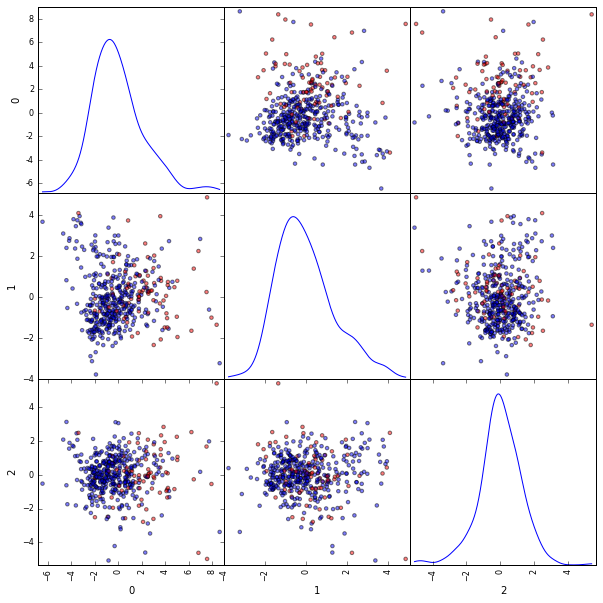

In [40]:
sm = pd.scatter_matrix(Xpc, 
                       alpha=0.5, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 50)
plt.savefig("Figures/PC_components_scatter_matrix.png")

In [41]:
%run -i 'support files/renders_PCA.py'

,Explained Variance,EDN3,GDI1,RALGPS1,SPAG1,GNE,FOXS1,MAP6D1,FAM72D,DRD5,...,AZGP1,DPM1,C8orf76,SNAPIN,FKBP15,HIST1H3J,UBE2D2,GGNBP2,MAPKAP1,NPTXR
Dimension 1,0.2484,-0.0709,0.2136,0.2997,0.2957,-0.1472,0.1172,0.2078,0.2327,-0.1511,...,-0.2587,0.2463,0.2356,0.1950,0.2692,0.1992,0.2494,0.2624,0.2353,-0.1779
Dimension 2,0.0997,0.0145,0.2394,-0.2847,0.0878,-0.4065,0.3080,0.1665,0.1503,-0.1967,...,0.1177,-0.0708,0.3022,0.1127,-0.4010,-0.0017,0.0560,-0.3762,-0.2077,-0.1662
Dimension 3,0.0795,-0.1544,0.2086,0.2329,-0.0370,-0.1718,0.1104,0.1826,-0.1955,-0.0207,...,-0.3208,-0.3915,-0.3103,-0.3700,0.0574,-0.0525,-0.2490,-0.1355,-0.1124,-0.2691


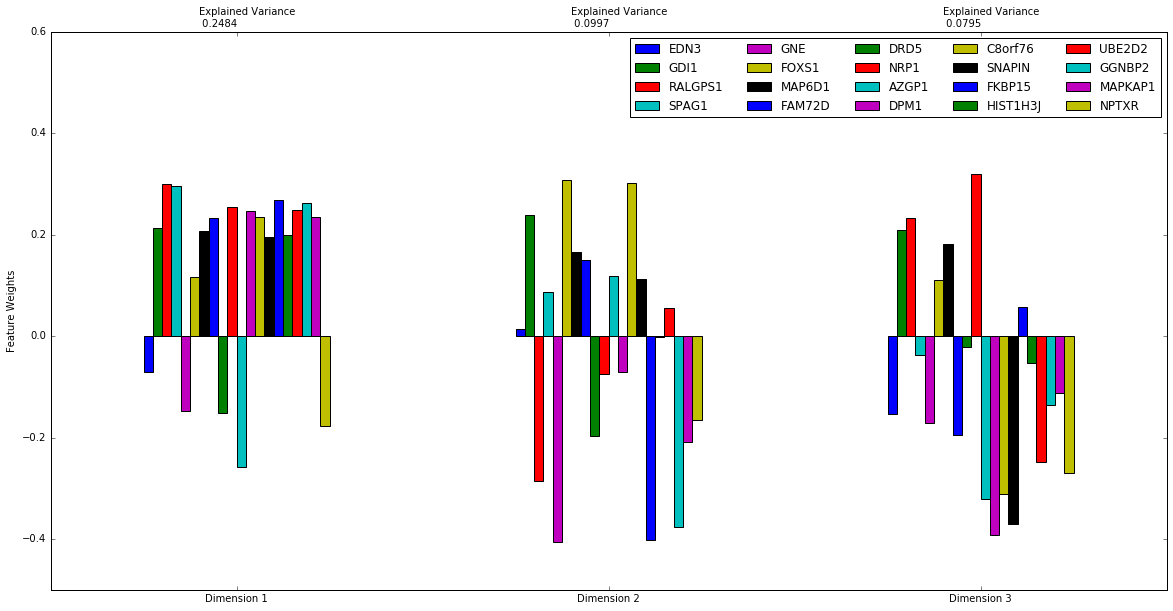

In [42]:
pca_results(Xs, pca)

#### Appropriate the PCA transformed dataset via the current train, test split index

In [43]:
X_train, X_test = Xpc.loc[X_train.index, :], Xpc.loc[X_test.index, :]

## Train the Logistic Regression Algorithm
Training with the first three principle components with cross validation to determine the optimal C parameter.

In [44]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [45]:
print("The optimal C term: ",clf_LR.C_)

The optimal C term:  [ 10000.]


### Visualize Model Performance on Training and Test sets

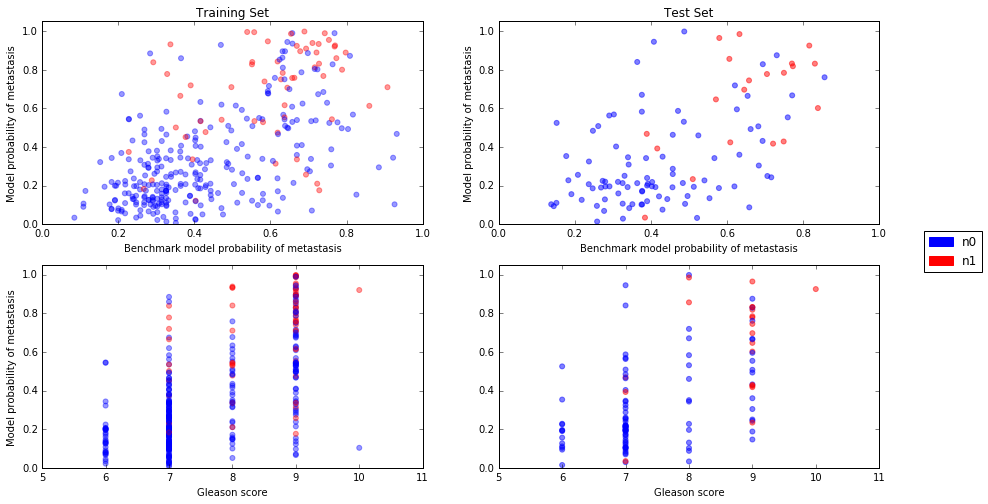

In [46]:
%run -i 'Support Files/capstone_graphs.py'
fig.savefig('Figures/bench_PC3.png')

### Measure Performance on the held-out test set

In [47]:
%run -i 'Support Files/capstone_performance.py'

Model:
 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F2 score:  0.575221238938

MCC:  0.363440767262 

             precision    recall  f1-score   support

         n0       0.91      0.78      0.84        92
         n1       0.39      0.65      0.49        20

avg / total       0.82      0.76      0.78       112


LogLoss:  0.523332618614


## Optimize the Logistic Regression Model
### Incorporate Gleason score

In [48]:
X_train.loc[:,'gleason'] = clinicalDF.loc[X_train.index,'gleason']
X_test.loc[:,'gleason'] = clinicalDF.loc[X_test.index, 'gleason']

### Retrain Logistic Regression model with CV for C term

In [49]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

#### Visualize Model Performance
Trained on First 3 PCs + gleason score

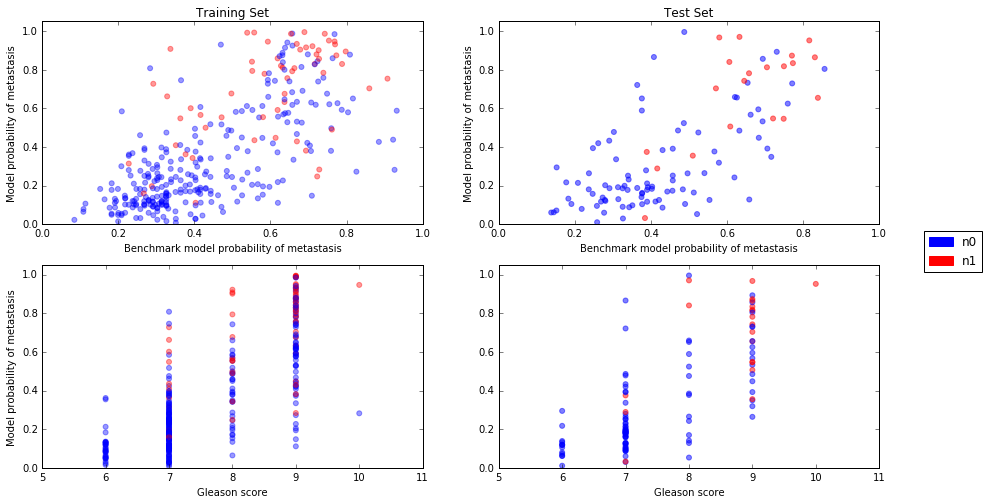

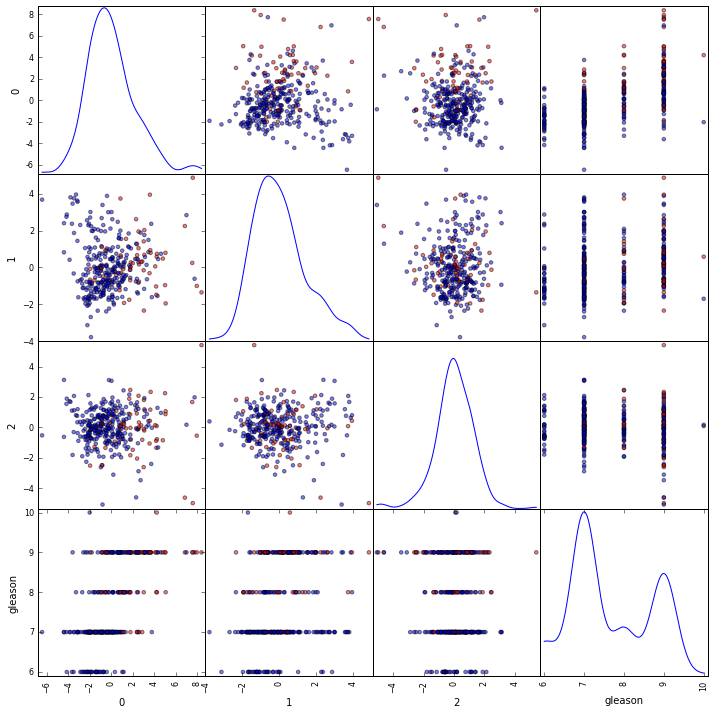

In [50]:
%run -i 'Support Files/capstone_graphs.py'
bench_fig.savefig('Figures/PC3_gs.png')
sm = pd.scatter_matrix(X_train, 
                       alpha=0.5, 
                       figsize= (12,12), 
                       diagonal = 'kde', 
                       c = y_train.replace({'n1': 'red','n0':'blue'}), 
                       s = 50)

#### Performance Measure

In [51]:
%run -i 'Support Files/capstone_performance.py'

Model:
 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F2 score:  0.70796460177

MCC:  0.516852950427 

             precision    recall  f1-score   support

         n0       0.95      0.82      0.88        92
         n1       0.48      0.80      0.60        20

avg / total       0.87      0.81      0.83       112


LogLoss:  0.489265950377


#### Is each feature important for model performance?

In [52]:
pd.DataFrame({'Component': X_train.columns, 'coef': clf_LR.coef_[0]})

,Component,coef
0,0,0.613019
1,1,-0.012797
2,2,-0.149155
3,gleason,0.401606


### Remove 2nd and 3rd PC from Feature set

In [53]:
X_train = X_train.drop([1, 2], axis=1)
X_test = X_test.drop([1,2], axis = 1)

In [54]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

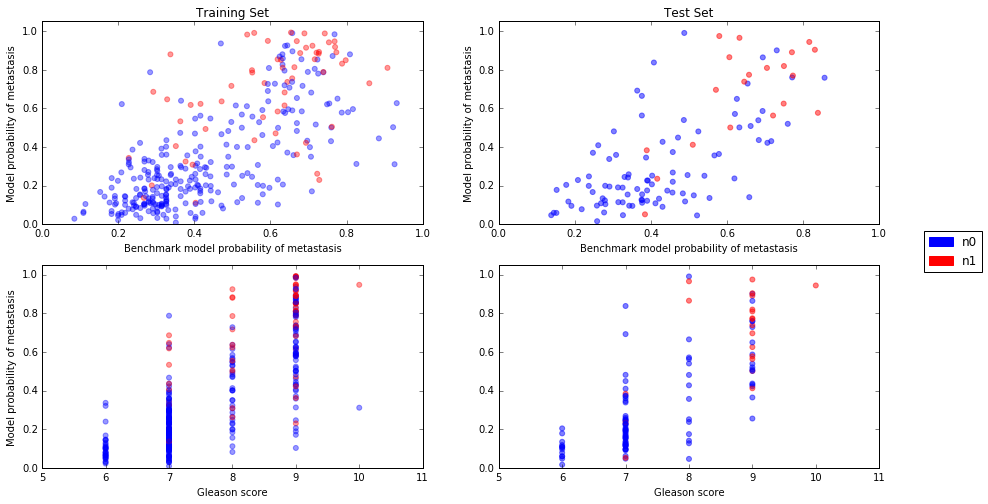

In [55]:
%run -i 'Support Files/capstone_graphs.py'
bench_fig.savefig('Figures/PC1_gs.png')


In [56]:
%run -i 'Support Files/capstone_performance.py'

Model:
 LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F2 score:  0.701754385965

MCC:  0.503395253029 

             precision    recall  f1-score   support

         n0       0.95      0.80      0.87        92
         n1       0.47      0.80      0.59        20

avg / total       0.86      0.80      0.82       112


LogLoss:  0.471712302566


In [57]:
pd.DataFrame({'Feature': X_train.columns, 'coef': clf_LR.coef_[0]})

,Feature,coef
0,0,0.589563
1,gleason,0.436138
